<h1>  Project of DDML </h1>

<h3>Author :</h3>
    <ul>
    <li> 
    Thibault POUX
    </li> 
    <li> 
    Pablo García
    </li> 
    <li> 
    Nabil Kaci 
    </li> 
    </ul>

<style>
.container {
    display: flex;
    flex-wrap: wrap;
    justify-content: center;
}

.image-group {
    display: flex;
    flex-direction: row;
    align-items: center;
    margin-bottom: 20px;
}

.image-box img {
    width: 300px; /* Adjust the width as needed */
    height: 300px; /* Adjust the height as needed */
    object-fit: cover;
}

.image-box img {
    max-width: 100%;
    height: auto;
}

.summary {
    margin-top: 20px;
}



.summary li {
    margin-bottom: 10px;
}
</style>

<div class="container">
    <div class="title">
        <h2>MRI Images of brain:</h2>
    </div>
    <div class="image-group">
        <div class="image-box">
            <img src="Dataset\no\no_3.jpg" alt="Image 1">
        </div>
        <div class="image-box">
            <img src="Dataset\no\no_78.jpg" alt="Image 2">
        </div>
    </div>
</div>

<div class="container">
    <div class="title">
        <h2>MRI Images for brain with a tumor:</h2>
    </div>
    <div class="image-group">
        <div class="image-box">
            <img src="Dataset\yes\yes_2.jpg" alt="Image 3">
        </div>
        <div class="image-box">
            <img src="Dataset\yes\yes_12.jpg" alt="Image 4">
        </div>
    </div>
</div>


<div class="summary">
    <h2>Summary</h2>
    <ul>
        <li>Number of cancer images: 155</li>
        <li>Number of non-cancer images: 98</li>
        <li>Link to dataset page: <a href="https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection">Kaggle.com</a></li>
    </ul>
</div>

In [1]:

# All import libraries
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, balanced_accuracy_score
import time

import numpy as np
import matplotlib.pyplot as plt

from tabulate import tabulate


# Homemade package
from codigo.prep_data import data_proccesing
from codigo.prep_data import data_preProcessing
from codigo import models

# Preporcessing the data if needed
data_preProcessing.run()

# Import the data
X_flatten, Y_flatten = data_proccesing.load_data_flatten()




Quadratic Model

In [ ]:
# Variables
r_state = [914, 895, 365, 264, 59, 500, 129]
pourcentage_of_test_data = 0.33

In [ ]:
# We define all the best models out of the knn and the mlp that are we gonna use

reg_Quadra = QuadraticDiscriminantAnalysis()   
reg_KNN = KNeighborsClassifier(n_neighbors=1)
reg_MLP = MLPClassifier(max_iter=10000, solver='adam', learning_rate_init=0.0001 , alpha=1e-5, hidden_layer_sizes=(12, 11))

# Dictionary to map readable names to model abbreviations
pretty_Names = {'quadra':'Quadratic Discriminant Analysis', 'knn':'K-Nearest Neighbors', 'mlp':'Multi-Layer Perceptron'}

# Dictionary to store model results
data = {'quadra':{}, 'knn':{}, 'mlp':{}}

# Initialize data within the dictionary
for key in data.keys():
    data[key]['f1'] = []
    data[key]['false_negatif'] = []
    data[key]['accuracy'] = [] 
    data[key]['time_fit'] = 0
    data[key]['time_predict'] = 0

# Loop for iterating over different random seeds
for int_state in r_state:


    # Splitting the data into train and test sets
    # Make the sample with houldout
    X_train, X_test, Y_train, Y_test = train_test_split(X_flatten, Y_flatten, test_size=pourcentage_of_test_data, random_state=int_state)

    
    #Loop for iterating over the models
    for reg, name in zip([reg_Quadra, reg_KNN, reg_MLP], data.keys()): 
        start_time = time.time()          # Start time for fitting
        reg = reg.fit(X_train, Y_train)   # Fitting the model
        end_fit = time.time()             # End time for fitting
        result = reg.predict(X_test)      # Predictions
        end_predict = time.time()         # End time for prediction
        
        # Calculating metrics and times
        data[name]['f1'].append(f1_score(Y_test, result, average='weighted'))                                  # F1 score
        data[name]['false_negatif'].append(confusion_matrix(Y_test, result).ravel()[2])    # False negatives
        data[name]['accuracy'].append(balanced_accuracy_score(Y_test, result))             # Balanced accuracy score
        data[name]['time_fit'] += end_fit - start_time                                     # Accumulated fitting time
        data[name]['time_predict'] += end_predict - end_fit                                # Accumulated prediction time

# Part to display the results

# Print the results in a table
output_data = []
for key in data.keys():
    name = pretty_Names.get(key)                                                        # Readable name of the model
    f1 = np.mean(data[key]['f1']).round(2)                                              # Average F1 score
    balanced_acc = np.mean(data[key]['accuracy']).round(2)                      # Average balanced accuracy
    f_neg = str((np.mean(data[key]['false_negatif'])/len(Y_test)*100).round(2)) + '%'   # Average false negatives
    time_fit = (data[key]['time_fit']/len(r_state))                                     # Average fitting time
    time_predict = (data[key]['time_predict']/len(r_state))                             # Average prediction time
    output_data.append([name, f1, f_neg, time_fit, time_predict])
    
# Print the results in a tabular format
print(f"Average of the different models, for {len(r_state)} different test, with {pourcentage_of_test_data*100}% of the data used the test set.")
print(tabulate(output_data, headers=['Model', 'F1 Score','Accuracy', 'False negative', 'Time to fit', 'Time to predict'], tablefmt='grid'))


# Plot a graph of the score for each model and for each iterration with a other curve for the average
plt.plot(data['quadra']['f1'], label='Quadratic', color='red')  # F1 scores for Quadratic Discriminant Analysis model
plt.plot(data['knn']['f1'], label='KNN', color='blue')          # F1 scores for K-Nearest Neighbors model
plt.plot(data['mlp']['f1'], label='MLP', color='green')         # F1 scores for Multi-Layer Perceptron model

# Dashed lines to represent the average F1 for each model
plt.plot([sum(data['quadra']['f1'])/len(data['quadra']['f1'])]*len(data['quadra']['f1']), label='Quadratic average',   color='red', linestyle='--')
plt.plot([sum(data['knn']['f1'])/len(data['knn']['f1'])]*len(data['knn']['f1']), label='KNN average', color='blue', linestyle='--')
plt.plot([sum(data['mlp']['f1'])/len(data['mlp']['f1'])]*len(data['mlp']['f1']), label='MLP average', color='green', linestyle='--')

plt.legend()        # Add legend to the plot
plt.show()          # Show the plot


<h2>Test for several neighbors in KNN, from 1 to 25.</h2>

In [2]:
# Getting all the data for the KNN model
array_numnber_of_neighboor = [i for i in range(1, 26, 1)]
data = models.KNN_range((X_flatten, Y_flatten), array_numnber_of_neighboor, size_sample=0.2)


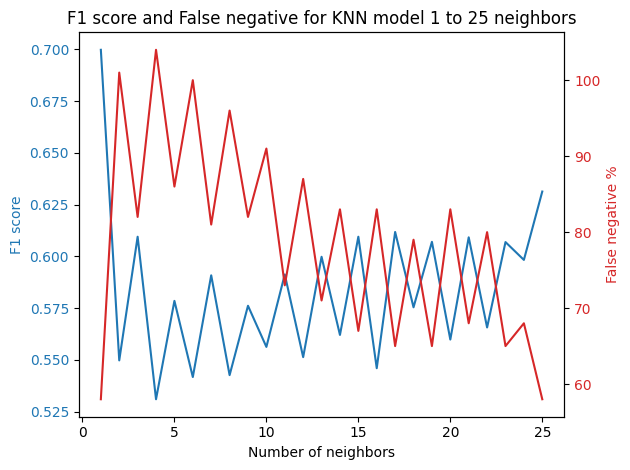

In [3]:
# Plotting the results to annlaysis the best number of neighbors for the KNN model
# Create a figure and subplots
fig, ax1 = plt.subplots()

# Plot F1 score on the first subplot
ax1.set_xlabel('Number of neighbors')                                                   # Set x-axis label
ax1.set_ylabel('F1 score', color='tab:blue')                                            # Set y-axis label for F1 score
ax1.plot(array_numnber_of_neighboor, data['f1'], color='tab:blue', label='F1 score')    # Plot F1 score
ax1.tick_params(axis='y', labelcolor='tab:blue')                                        # Set y-axis ticks color for F1 score

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()                                                                           # Create a second y-axis
ax2.set_ylabel('False negative %', color='tab:red')                                         # Set y-axis label for false negative percentage
ax2.plot(array_numnber_of_neighboor, data['fn'], color='tab:red', label='False negative')   # Plot false negative percentage
ax2.tick_params(axis='y', labelcolor='tab:red')                                             # Set y-axis ticks color for false negative percentage

plt.title('F1 score and False negative for KNN model 1 to 25 neighbors')    # Set title of the plot
fig.tight_layout()                                                          # Adjust layout
plt.show()                                                                  # Show the plot

<h1>KNN Model Evaluation</h1>
<p>I can see that the number of neighbors that gives the best result is about 20 (it depends on the seeds, but we can say 21). This value is the best because it maximizes the F1 score while also minimizing the false negative rate. </p>
<p>We are choosing 21 over 25 even though the results are similar because with fewer neighbors the algorithm is more efficient.</p>

<p>Best value of K: 21</p>

<h2>MLP</h2>

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import balanced_accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

# Let's assume X_flatten and Y_flatten are your data
# X_flatten is a feature matrix and Y_flatten are the labels

# First, we split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_flatten, Y_flatten, test_size=0.2, random_state=59)

# Define lists to store the results
neurons_range = range(1, 16)                                            # Range of neurons for hidden layers
accuracies = np.zeros((len(neurons_range), len(neurons_range)))         # Array to store accuracies
f1_scores = np.zeros((len(neurons_range), len(neurons_range)))          # Array to store F1 scores
falseNegatives = np.zeros((len(neurons_range), len(neurons_range)))     # Array to store false negatives

# Train several MLPs with different configurations
for i, neurons1 in enumerate(neurons_range):
    for j, neurons2 in enumerate(neurons_range):
        
        # Create MLP with current configuration
        mlp = MLPClassifier(max_iter=10000, hidden_layer_sizes=(neurons1,neurons2) , learning_rate_init=0.0001, solver='adam', alpha=1e-5,random_state=59)
        
        # Fit MLP to training data
        mlp.fit(X_train, y_train)
        
        # Predict on test data
        y_pred = mlp.predict(X_test)
        
        # Calculate accuracy, F1 score, and false negatives
        acc = balanced_accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        accuracies[i, j] = acc
        f1_scores[i, j] = f1
        falseNegatives[i,j]= confusion_matrix(y_test, y_pred).ravel()[2]
        


In [ ]:
# Plotting accuracy heatmap with annotations
plt.figure(figsize=(10, 6))                                         # Create a figure with a specific size
plt.imshow(accuracies, interpolation='nearest', cmap=plt.cm.Blues)  # Display accuracy heatmap
plt.title('Accuracy Heatmap')                                       # Set title for the plot
plt.xlabel('Neurons in Layer 1')                                    # Set label for x-axis
plt.ylabel('Neurons in Layer 2')                                    # Set label for y-axis
plt.colorbar(label='Accuracy')                                      # Add colorbar with label
plt.xticks(np.arange(len(neurons_range)), neurons_range)            # Set ticks and labels for x-axis
plt.yticks(np.arange(len(neurons_range)), neurons_range)            # Set ticks and labels for y-axis

for i in range(len(neurons_range)):
    for j in range(len(neurons_range)):
        
        # Annotate heatmap with accuracy value
        plt.text(j, i, f'{accuracies[i, j]:.2f}', ha='center', va='center', color='black')
plt.show()

# Plotting F1 score heatmap with annotations
plt.figure(figsize=(10, 6))                                         # Create a figure with a specific size
plt.imshow(f1_scores, interpolation='nearest', cmap=plt.cm.Reds)    # Display F1 score heatmap
plt.title('F1 Score Heatmap')                                       # Set title for the plot
plt.xlabel('Neurons in Layer 1')                                    # Set label for x-axis
plt.ylabel('Neurons in Layer 2')                                    # Set label for y-axis
plt.colorbar(label='F1 Score')                                      # Add colorbar with label
plt.xticks(np.arange(len(neurons_range)), neurons_range)            # Set ticks and labels for x-axis
plt.yticks(np.arange(len(neurons_range)), neurons_range)            # Set ticks and labels for y-axis

for i in range(len(neurons_range)):
    for j in range(len(neurons_range)):
        
        # Annotate heatmap with F1 score values
        plt.text(j, i, f'{f1_scores[i, j]:.2f}', ha='center', va='center', color='black')
plt.show()

# Plotting false negatives heatmap
plt.figure(figsize=(10, 6))                                                 # Create a figure with a specific size
plt.imshow(falseNegatives, interpolation='nearest', cmap=plt.cm.Greens)     # Display false negatives heatmap
plt.title('False Negatives Heatmap')                                        # Set title for the plot
plt.xlabel('Neurons in Layer 1')                                            # Set label for x-axis
plt.ylabel('Neurons in Layer 2')                                            # Set label for y-axis
plt.colorbar(label='False Negatives')                                       # Add colorbar with label
plt.xticks(np.arange(len(neurons_range)), neurons_range)                    # Set ticks and labels for x-axis
plt.yticks(np.arange(len(neurons_range)), neurons_range)                    # Set ticks and labels for y-axis

for i in range(len(neurons_range)):
    for j in range(len(neurons_range)):
        
        # Annotate heatmap with false negative values
        plt.text(j, i, f'{falseNegatives[i, j]:.0f}', ha='center', va='center', color='black')
plt.show()

<h2>CNN </h2>

In [ ]:
import numpy as np
import random
import glob
import cv2

from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import F1Score
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from sklearn.model_selection import train_test_split

# Homemade package
from codigo.prep_data import data_proccesing
from codigo.prep_data import data_preProcessing

# Preporcessing the data if needed
data_preProcessing.run()

# Import the data
X_flatten, Y_flatten = data_proccesing.load_data()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_flatten, Y_flatten, test_size=0.2)

# Reshape the labels
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [ ]:
# Create the model
# Initialize a Sequential model
model = Sequential()

# Add Convolutional and Pooling layers
model.add(Conv2D(32,(3,3),activation= 'relu', input_shape =(128, 128, 1) ))   # Add Conv2D layer with 32 filters, relu activation function, and input shape
model.add(MaxPooling2D((2,2)))                                                # Add MaxPooling2D layer with pool size (2,2)
model.add(Conv2D(32,(3,3),activation= 'relu'))                                # Add another Conv2D layer with 32 filters and relu activation function
model.add(MaxPooling2D((2,2)))                                                # Add another MaxPooling2D layer with pool size (2,2)

# Flatten the output from Convolutional layers
model.add(Flatten())                            # Flatten the output from Convolutional and Pooling layers                                           

# Add Dense layers
model.add(Dense(65, activation='relu'))         # Add Dense layer with 65 neurons and relu activation function
model.add(Dense(1, activation= 'sigmoid'))      # Add Dense layer with 1 neuron and sigmoid activation function


# Print model summary
model.summary()                                 # Print a summary of the model architecture


In [ ]:
# Assuming y_pred and y_true are numpy arrays
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

In [ ]:

# Define F1 score metric
f1 = F1Score(average=None, threshold=None, name="f1_score", dtype=None)  
model.compile(loss='binary_crossentropy', optimizer='adam', metrics= ['accuracy',f1])   # Compile the model with binary crossentropy loss, Adam optimizer, and accuracy and F1 score metrics 
model.fit(X_train,y_train, epochs= 10, batch_size=64 ,class_weight={0: 155/253, 1: 98/253})                                   # Train the model on X_train and y_train data for 10 epochs with a batch size of 64

In [ ]:
model.evaluate(X_test, y_test)      # Evaluate the trained model on X_test and y_test data